# Cutting Stock Problem with Column Generation

This notebook demonstrates how to solve the **Cutting Stock Problem (CSP)** using the OpenCG column generation framework.

## Problem Description

Given:
- A stock roll of width $W$
- $n$ item types with widths $w_i$ and demands $d_i$

Find the minimum number of stock rolls to cut to satisfy all demands.

## Column Generation Approach

**Master Problem**: Select patterns to minimize total rolls used
- Each pattern specifies how many of each item type to cut from one roll
- Constraint: Meet demand for each item type

**Pricing Problem**: Find new patterns with negative reduced cost
- Bounded knapsack: maximize dual value, subject to width constraint
- A pattern with negative reduced cost can improve the solution

In [39]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from opencg.applications.cutting_stock import (
    CuttingStockInstance,
    CuttingStockSolution,
    solve_cutting_stock,
)

## Example 1: Simple Instance

Let's start with a small instance to understand how the algorithm works.

In [40]:
# Create a simple instance
# Stock roll width: 100 units
# Items: 4 types with different sizes and demands

instance = CuttingStockInstance(
    roll_width=100,
    item_sizes=[45, 36, 31, 14],      # Item sizes (widths)
    item_demands=[97, 610, 395, 211],  # How many of each we need
    name="simple_example"
)

print(f"Instance: {instance.name}")
print(f"Roll width: {instance.roll_width}")
print(f"Number of item types: {instance.num_items}")
print(f"Total demand: {instance.total_demand}")
print()
print("Items:")
for i in range(instance.num_items):
    print(f"  Type {i}: size={instance.item_sizes[i]}, demand={instance.item_demands[i]}")

Instance: simple_example
Roll width: 100
Number of item types: 4
Total demand: 1313

Items:
  Type 0: size=45, demand=97
  Type 1: size=36, demand=610
  Type 2: size=31, demand=395
  Type 3: size=14, demand=211


In [41]:
# Solve with column generation
solution = solve_cutting_stock(instance, max_iterations=50, verbose=True)

L2 lower bound: 416
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
FFD heuristic: 485 patterns (upper bound)
LP has 4 rows; 489 cols; 597 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 7e+00]
  Cost    [1e+00, 1e+00]
  Bound   [0e+00, 0e+00]
  RHS     [1e+02, 6e+02]
Presolving model
4 rows, 110 cols, 218 nonzeros  0s
4 rows, 6 cols, 10 nonzeros  0s
4 rows, 6 cols, 10 nonzeros  0s
Presolve reductions: rows 4(-0); columns 6(-483); nonzeros 10(-587) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 4(1115.5) 0s
          3     4.5225000000e+02 Pr: 0(0) 0s

Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Iter 0: obj=452.2500, cols=489
Converged - no columns with negative reduced cost
Simplex   iterations: 3
Objective value     :  4.5225000000e+02
P-D objective error :  0.0000000

In [42]:
# Examine the solution
print(f"\nSolution Summary:")
print(f"  LP relaxation: {solution.lp_objective:.2f} rolls")
print(f"  Integer solution: {solution.num_rolls_ip} rolls")
print(f"  Lower bound (L2): {solution.lower_bound}")
print(f"  Solve time: {solution.solve_time:.3f}s")
print(f"  CG iterations: {solution.iterations}")
print(f"  Patterns generated: {solution.num_columns}")


Solution Summary:
  LP relaxation: 452.25 rolls
  Integer solution: 453 rolls
  Lower bound (L2): 416
  Solve time: 0.117s
  CG iterations: 1
  Patterns generated: 489


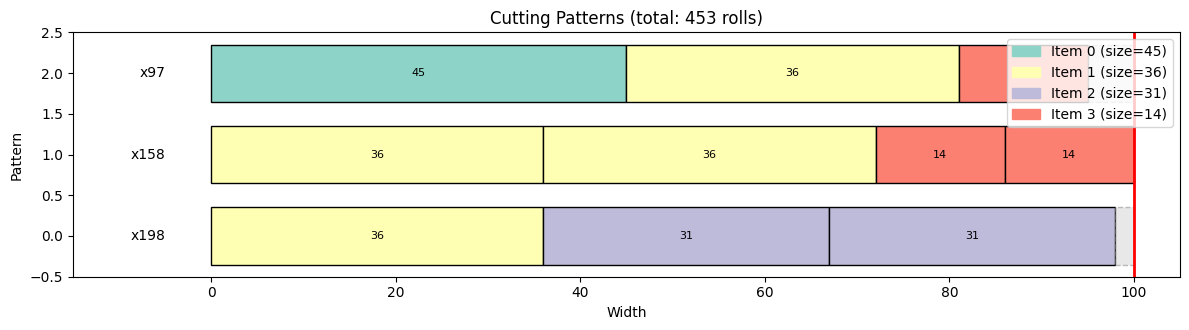

In [43]:
# Visualize the patterns used in the solution
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_patterns(instance, solution, max_patterns=10):
    """Visualize cutting patterns as horizontal bar charts."""
    if not solution.patterns:
        print("No patterns to visualize")
        return
    
    # Get patterns with positive usage
    # patterns is List[Tuple[Dict[int, int], float]] - (pattern_dict, count)
    used_patterns = [(p, u) for p, u in solution.patterns if u > 0]
    used_patterns = used_patterns[:max_patterns]
    
    if not used_patterns:
        print("No patterns used")
        return
    
    colors = plt.cm.Set3(range(instance.num_items))
    
    fig, ax = plt.subplots(figsize=(12, len(used_patterns) * 0.8 + 1))
    
    for idx, (pattern_dict, usage) in enumerate(used_patterns):
        y = len(used_patterns) - idx - 1
        x = 0
        
        for item_idx in range(instance.num_items):
            count = pattern_dict.get(item_idx, 0)
            size = instance.item_sizes[item_idx]
            for _ in range(count):
                rect = mpatches.Rectangle(
                    (x, y - 0.35), size, 0.7,
                    linewidth=1, edgecolor='black',
                    facecolor=colors[item_idx]
                )
                ax.add_patch(rect)
                ax.text(x + size/2, y, f"{int(size)}", 
                       ha='center', va='center', fontsize=8)
                x += size
        
        # Show waste
        waste = instance.roll_width - x
        if waste > 0:
            rect = mpatches.Rectangle(
                (x, y - 0.35), waste, 0.7,
                linewidth=1, edgecolor='gray', linestyle='--',
                facecolor='lightgray', alpha=0.5
            )
            ax.add_patch(rect)
        
        ax.text(-5, y, f"x{usage:.0f}", ha='right', va='center', fontsize=10)
    
    ax.set_xlim(-15, instance.roll_width + 5)
    ax.set_ylim(-0.5, len(used_patterns) - 0.5)
    ax.set_xlabel('Width')
    ax.set_ylabel('Pattern')
    ax.set_title(f'Cutting Patterns (total: {solution.num_rolls_ip} rolls)')
    ax.axvline(x=instance.roll_width, color='red', linestyle='-', linewidth=2, label='Roll width')
    
    # Legend for item types
    legend_patches = [mpatches.Patch(color=colors[i], label=f'Item {i} (size={int(instance.item_sizes[i])})') 
                     for i in range(instance.num_items)]
    ax.legend(handles=legend_patches, loc='upper right')
    
    plt.tight_layout()
    plt.show()

visualize_patterns(instance, solution)

## Example 2: Loading a BPPLIB Instance

BPPLIB is a standard benchmark library for bin packing and cutting stock problems. Let's load and solve one of the standard instances.

In [44]:
# Load a BPPLIB instance (if available)
bpplib_path = project_root / "data" / "bpplib" / "Instances" / "Benchmarks" / "extracted" / "Scholl_CSP" / "Scholl_1"

if bpplib_path.exists():
    # Get first instance
    instance_files = sorted(bpplib_path.glob("*.txt"))
    if instance_files:
        instance_file = instance_files[0]
        print(f"Loading: {instance_file.name}")
        
        instance = CuttingStockInstance.from_bpplib(str(instance_file))
        print(f"Instance: {instance.name}")
        print(f"Roll width: {instance.roll_width}")
        print(f"Item types: {instance.num_items}")
        print(f"Total demand: {instance.total_demand}")
else:
    print("BPPLIB instances not found. Using synthetic data.")
    print("To download BPPLIB, visit: http://or.dei.unibo.it/library/bpplib")

Loading: N1C1W1_A.txt
Instance: N1C1W1_A
Roll width: 100
Item types: 41
Total demand: 50


In [45]:
# Solve the BPPLIB instance
if 'instance' in dir() and instance.num_items > 4:
    solution = solve_cutting_stock(instance, max_iterations=100, verbose=True)
    
    print(f"\nSolution:")
    print(f"  LP: {solution.lp_objective:.2f}")
    print(f"  IP: {solution.num_rolls_ip}")
    print(f"  L2 bound: {solution.lower_bound}")
    print(f"  Gap: {100*(solution.num_rolls_ip - solution.lower_bound)/solution.lower_bound:.1f}%" 
          if solution.lower_bound else "N/A")

L2 lower bound: 25
FFD heuristic: 25 patterns (upper bound)
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 41 rows; 66 cols; 91 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 3e+01]
  Cost    [1e+00, 1e+00]
  Bound   [0e+00, 0e+00]
  RHS     [1e+00, 2e+00]
Presolving model
41 rows, 46 cols, 71 nonzeros  0s
7 rows, 11 cols, 15 nonzeros  0s
5 rows, 7 cols, 11 nonzeros  0s
Presolve reductions: rows 5(-36); columns 7(-59); nonzeros 11(-80) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     2.2950000000e+01 Pr: 5(6) 0s
          5     2.4950000000e+01 Pr: 0(0) 0s

Performed postsolve
Solving the original LP from the solution after postsolve

Iter 0: obj=24.9500, cols=66
Model status        : Optimal
Simplex   iterations: 5
Objective value     :  2.4950000000e+01
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00
LP has 41 rows; 6

## Understanding the Column Generation Process

Let's trace through the column generation process step by step.

In [46]:
# Create a small instance for detailed tracing
instance = CuttingStockInstance(
    roll_width=10,
    item_sizes=[4, 3, 2],
    item_demands=[5, 8, 10],
    name="trace_example"
)

print("Instance:")
print(f"  Roll width: {instance.roll_width}")
for i in range(instance.num_items):
    print(f"  Item {i}: size={instance.item_sizes[i]}, demand={instance.item_demands[i]}")

Instance:
  Roll width: 10
  Item 0: size=4, demand=5
  Item 1: size=3, demand=8
  Item 2: size=2, demand=10


In [47]:
# Solve with verbose output
solution = solve_cutting_stock(instance, max_iterations=20, verbose=True)

L2 lower bound: 7
FFD heuristic: 7 patterns (upper bound)
Running HiGHS 1.12.0 (git hash: 755a8e0): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 3 rows; 10 cols; 13 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 5e+00]
  Cost    [1e+00, 1e+00]
  Bound   [0e+00, 0e+00]
  RHS     [5e+00, 1e+01]
Presolving model
3 rows, 5 cols, 8 nonzeros  0s
3 rows, 4 cols, 6 nonzeros  0s
Presolve reductions: rows 3(-0); columns 4(-6); nonzeros 6(-7) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 3(23) 0s
          4     6.4000000000e+00 Pr: 0(0) 0s

Performed postsolve
Solving the original LP from the solution after postsolve

Iter 0: obj=6.4000, cols=10
Converged - no columns with negative reduced cost
Model status        : Optimal
Simplex   iterations: 4
Objective value     :  6.4000000000e+00
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00
MIP has 3 r

In [48]:
# Show final patterns
print("\nPatterns used in solution:")
for i, (pattern_dict, usage) in enumerate(solution.patterns):
    if usage > 0:
        total_width = sum(count * instance.item_sizes[item_id] 
                         for item_id, count in pattern_dict.items())
        waste = instance.roll_width - total_width
        pattern_str = ", ".join(f"item{k}:{v}" for k, v in sorted(pattern_dict.items()))
        print(f"  Pattern {i}: {{{pattern_str}}} x {usage:.0f} (width used: {total_width}, waste: {waste})")


Patterns used in solution:
  Pattern 0: {item0:2, item2:1} x 1 (width used: 10, waste: 0)
  Pattern 1: {item0:1, item1:2} x 4 (width used: 10, waste: 0)
  Pattern 2: {item2:5} x 2 (width used: 10, waste: 0)


In [49]:
# Verify solution covers all demands
print("\nDemand coverage:")
for i in range(instance.num_items):
    produced = sum(pattern_dict.get(i, 0) * usage 
                   for pattern_dict, usage in solution.patterns if usage > 0)
    print(f"  Item {i}: needed={instance.item_demands[i]}, produced={produced:.0f}")


Demand coverage:
  Item 0: needed=5, produced=6
  Item 1: needed=8, produced=8
  Item 2: needed=10, produced=11


## Summary

Key concepts demonstrated:

1. **Column Generation**: Start with simple patterns, iteratively add better ones
2. **Pricing Problem**: Find patterns that could improve the solution
3. **LP vs IP**: LP relaxation gives lower bound, IP gives integer solution
4. **L2 Lower Bound**: Continuous lower bound based on total width

The cutting stock solver in OpenCG:
- Uses FFD (First Fit Decreasing) heuristic for initial patterns
- Solves bounded knapsack for pricing
- Typically converges in few iterations for practical instances